**Mount Google Drive To Retrieve Data From Cloud Storage**

In [ ]:
# Dataset: https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


**Import Dependencies**

In [ ]:
import numpy as np
import pandas as pd
import wordcloud
from matplotlib import pyplot as plt
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Embedding, Bidirectional
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization 
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix

**Load and Display Cleaned Data**

In [ ]:
# Load raw pre-cleaned data
SAVE_PATH = 'gdrive/MyDrive/Sentiment_Analysis/'
data = pd.read_csv(SAVE_PATH + 'data/Cleaned_No_Stemming_IMDB_Dataset.csv')
data.review = data.review.astype(str)

print(data.head)
print("\n", data.shape)

<bound method NDFrame.head of                                                   review sentiment
0      one reviewers mentioned watching oz episode yo...  positive
1      wonderful little production filming technique ...  positive
2      thought wonderful way spend time hot summer we...  positive
3      basically theres family little boy jake thinks...  negative
4      petter matteis love time money visually stunni...  positive
...                                                  ...       ...
49995  thought movie right good job wasnt creative or...  positive
49996  bad plot bad dialogue bad acting idiotic direc...  negative
49997  catholic taught parochial elementary schools n...  negative
49998  im going disagree previous comment side maltin...  negative
49999  one expects star trek movies high art fans exp...  negative

[50000 rows x 2 columns]>

 (50000, 2)


**Separate Review Text and Labels**

In [ ]:
x_vals = data['review'].values
y_vals = data['sentiment'].values
print("Review Text:\n------------\n", x_vals)
print("\nSentiment:\n----------\n", y_vals)

Review Text:
------------
 ['one reviewers mentioned watching oz episode youll hooked right exactly happened methe first thing struck oz brutality unflinching scenes violence set right word go trust show faint hearted timid show pulls punches regards drugs sex violence hardcore classic use wordit called oz nickname given oswald maximum security state penitentary focuses mainly emerald city experimental section prison cells glass fronts face inwards privacy high agenda em city home manyaryans muslims gangstas latinos christians italians irish moreso scuffles death stares dodgy dealings shady agreements never far awayi would say main appeal show due fact goes shows wouldnt dare forget pretty pictures painted mainstream audiences forget charm forget romanceoz doesnt mess around first episode ever saw struck nasty surreal couldnt say ready watched developed taste oz got accustomed high levels graphic violence violence injustice crooked guards wholl sold nickel inmates wholl kill order get 

**Use Text Vectorization Layer**

In [ ]:
VOCAB_SIZE = 1000
vectorizer = TextVectorization(max_tokens=VOCAB_SIZE)
vectorizer.adapt(x_vals)

In [ ]:
vocab = np.array(vectorizer.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'movie', 'film', 'one', 'like', 'good', 'even',
       'would', 'time', 'really', 'see', 'story', 'much', 'well', 'get',
       'great', 'bad', 'also', 'people'], dtype='<U14')

**Reshape Review Text**

In [ ]:
x_vals.resize((x_vals.shape[0], 1))
x_vals = np.asarray(x_vals).astype(np.str)

print(x_vals)
print("\n", x_vals.shape)

[['one reviewers mentioned watching oz episode youll hooked right exactly happened methe first thing struck oz brutality unflinching scenes violence set right word go trust show faint hearted timid show pulls punches regards drugs sex violence hardcore classic use wordit called oz nickname given oswald maximum security state penitentary focuses mainly emerald city experimental section prison cells glass fronts face inwards privacy high agenda em city home manyaryans muslims gangstas latinos christians italians irish moreso scuffles death stares dodgy dealings shady agreements never far awayi would say main appeal show due fact goes shows wouldnt dare forget pretty pictures painted mainstream audiences forget charm forget romanceoz doesnt mess around first episode ever saw struck nasty surreal couldnt say ready watched developed taste oz got accustomed high levels graphic violence violence injustice crooked guards wholl sold nickel inmates wholl kill order get away well mannered middle 

**Reshape Sentiment Labels**

In [ ]:
# Convert positive labels to 1, negative to 0
y_vals[y_vals == 'positive'] = 1
y_vals[y_vals == 'negative'] = 0
y_vals.resize((y_vals.shape[0], 1))
y_vals = np.asarray(y_vals).astype(np.int)

print(y_vals)
print("\n", y_vals.shape)

[[1]
 [1]
 [1]
 ...
 [0]
 [0]
 [0]]

 (50000, 1)


**Partition Data**

In [ ]:
from sklearn.model_selection import train_test_split

# Randomize and split entire dataset into 80% train, 20% testing
x_train, x_test, y_train, y_test = train_test_split(x_vals, y_vals, test_size=.2, random_state=5)

print("Training:", x_train.shape, y_train.shape)
print("Testing:", x_test.shape, y_test.shape)


Training: (40000, 1) (40000, 1)
Testing: (10000, 1) (10000, 1)


**Build Model**

In [ ]:
model = Sequential([
    vectorizer,
    Embedding(
        input_dim=len(vectorizer.get_vocabulary()),
        output_dim=64,
        mask_zero=True      # Masking accounts for differing lengths
    ),
    Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    Bidirectional(tf.keras.layers.LSTM(32)),
    Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    Dense(1)
])

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

**Train Model**

In [ ]:
# Pocket algorithm, save a checkpoint of model
# each time validation accuracy increases
SAVE_PATH = 'gdrive/MyDrive/Sentiment_Analysis/'

checkpoint = ModelCheckpoint(SAVE_PATH + 'Stacked_LSTM_UNSTEMMED', monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)

# Monitor whether validation loss decreased from last epoch, stop training
# if did not decrease in the last 2 epochs and restore weights to last decrease
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2, restore_best_weights=True)

history = model.fit(
    x = x_train, 
    y = y_train, 
    validation_data = (x_test, y_test), 
    validation_steps=30,
    epochs = 10,
    callbacks=[checkpoint, es]
)

Epoch 1/10
1250/1250 [==============================] - 1322s 1s/step - loss: 0.5891 - accuracy: 0.6218 - val_loss: 0.3360 - val_accuracy: 0.8484

Epoch 00001: val_accuracy improved from -inf to 0.84840, saving model to gdrive/MyDrive/Sentiment_Analysis/GloVe_Bidirect_Stacked_LSTM_UNSTEMMED


INFO:tensorflow:Assets written to: gdrive/MyDrive/Sentiment_Analysis/GloVe_Bidirect_Stacked_LSTM_UNSTEMMED/assets


INFO:tensorflow:Assets written to: gdrive/MyDrive/Sentiment_Analysis/GloVe_Bidirect_Stacked_LSTM_UNSTEMMED/assets


Epoch 2/10
1250/1250 [==============================] - 1274s 1s/step - loss: 0.3408 - accuracy: 0.8505 - val_loss: 0.3245 - val_accuracy: 0.8545

Epoch 00002: val_accuracy improved from 0.84840 to 0.85450, saving model to gdrive/MyDrive/Sentiment_Analysis/GloVe_Bidirect_Stacked_LSTM_UNSTEMMED


INFO:tensorflow:Assets written to: gdrive/MyDrive/Sentiment_Analysis/GloVe_Bidirect_Stacked_LSTM_UNSTEMMED/assets


INFO:tensorflow:Assets written to: gdrive/MyDrive/Sentiment_Analysis/GloVe_Bidirect_Stacked_LSTM_UNSTEMMED/assets


Epoch 3/10
1250/1250 [==============================] - 1332s 1s/step - loss: 0.3192 - accuracy: 0.8634 - val_loss: 0.3244 - val_accuracy: 0.8560

Epoch 00003: val_accuracy improved from 0.85450 to 0.85600, saving model to gdrive/MyDrive/Sentiment_Analysis/GloVe_Bidirect_Stacked_LSTM_UNSTEMMED


INFO:tensorflow:Assets written to: gdrive/MyDrive/Sentiment_Analysis/GloVe_Bidirect_Stacked_LSTM_UNSTEMMED/assets


INFO:tensorflow:Assets written to: gdrive/MyDrive/Sentiment_Analysis/GloVe_Bidirect_Stacked_LSTM_UNSTEMMED/assets


Epoch 4/10
1250/1250 [==============================] - 1353s 1s/step - loss: 0.3139 - accuracy: 0.8615 - val_loss: 0.3333 - val_accuracy: 0.8327

Epoch 00004: val_accuracy did not improve from 0.85600
Epoch 5/10
1250/1250 [==============================] - 1359s 1s/step - loss: 0.3031 - accuracy: 0.8682 - val_loss: 0.3288 - val_accuracy: 0.8587

Epoch 00005: val_accuracy improved from 0.85600 to 0.85870, saving model to gdrive/MyDrive/Sentiment_Analysis/GloVe_Bidirect_Stacked_LSTM_UNSTEMMED


INFO:tensorflow:Assets written to: gdrive/MyDrive/Sentiment_Analysis/GloVe_Bidirect_Stacked_LSTM_UNSTEMMED/assets


INFO:tensorflow:Assets written to: gdrive/MyDrive/Sentiment_Analysis/GloVe_Bidirect_Stacked_LSTM_UNSTEMMED/assets


Restoring model weights from the end of the best epoch.
Epoch 00005: early stopping


**Plot Training History**

In [ ]:
import json
SAVE_PATH = 'gdrive/MyDrive/Sentiment_Analysis/'

with open(SAVE_PATH + 'LSTM_stacked_unstemmed_training.json', 'w') as file:
  json.dump(history.history, file)

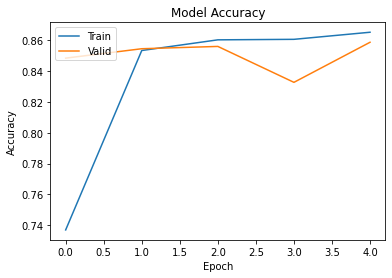

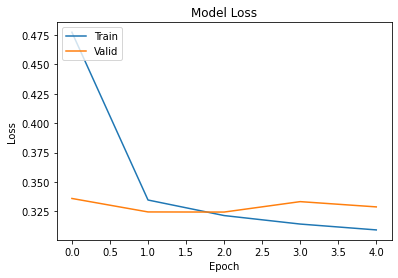

In [ ]:
# Plot history of accuracy during training
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.savefig(SAVE_PATH + 'figures/acc_plot_stacked_UNSTEMMED.png')
plt.show()

# Plot history of loss during training
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.savefig(SAVE_PATH + 'figures/loss_plot_stacked_UNSTEMMED.png')
plt.show()

**Load and Test Model**

In [ ]:
model = load_model(SAVE_PATH + 'Stacked_LSTM_UNSTEMMED')
model.evaluate(x=x_test, y=y_test)
model.summary()

313/313 [==============================] - 78s 230ms/step - loss: 0.3288 - accuracy: 0.8587
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, None)              0         
_________________________________________________________________
embedding_3 (Embedding)      (None, None, 64)          64000     
_________________________________________________________________
bidirectional_6 (Bidirection (None, None, 128)         66048     
_________________________________________________________________
bidirectional_7 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
____________________________

**Plot Confusion Matrix**

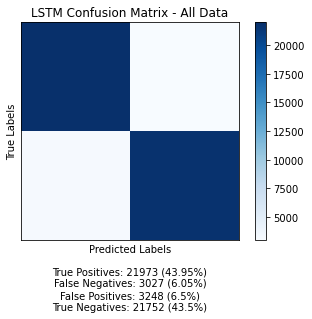

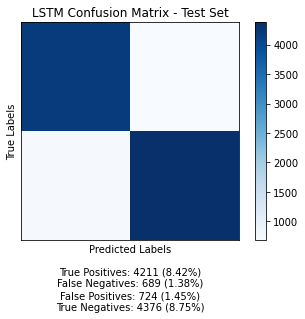

In [ ]:
def get_caption(cm):
  return "\n\nTrue Positives: {} ({}%)\nFalse Negatives: {} ({}%)\nFalse Positives: {} ({}%)\nTrue Negatives: {} ({}%)".format(
    str(cm[0][0]), str(round((cm[0][0]/len(x_vals))*100, 2)),
    str(cm[0][1]), str(round((cm[0][1]/len(x_vals))*100, 2)),
    str(cm[1][0]), str(round((cm[1][0]/len(x_vals))*100, 2)),
    str(cm[1][1]), str(round((cm[1][1]/len(x_vals))*100, 2))
  )
  
# Generate predictions on full dataset
y_preds = model.predict(x_vals)
y_preds = np.where(y_preds > 0.5, 1, 0)
cm = confusion_matrix(y_vals, y_preds)

# Plot confusion matrix
plt.imshow(cm, cmap=plt.cm.Blues)
plt.xlabel("Predicted Labels" + get_caption(cm))
plt.ylabel("True Labels")
plt.xticks([], [])
plt.yticks([], [])
plt.title('LSTM Confusion Matrix - All Data')
plt.colorbar()
plt.savefig(SAVE_PATH + 'figures/confusion_matrix_alldata.png', bbox_inches='tight')
plt.show()


# Generate predictions on testing set
y_test_preds = model.predict(x_test)
y_test_preds = np.where(y_test_preds > 0.5, 1, 0)
cm = confusion_matrix(y_test, y_test_preds)

# Plot confusion matrix
plt.imshow(cm, cmap=plt.cm.Blues)
plt.xlabel("Predicted Labels" + get_caption(cm))
plt.ylabel("True Labels")
plt.xticks([], [])
plt.yticks([], [])
plt.title('LSTM Confusion Matrix - Test Set')
plt.colorbar()
plt.savefig(SAVE_PATH + 'figures/confusion_matrix_testdata.png', bbox_inches='tight')
plt.show()

**Analyze Results**

In [ ]:
# Display messages incorrectly classified
misclass_data = data.loc[y_preds != y_vals]
print("Stemmed Text Given to Model:\n", misclass_data)

# Display the unstemmed version of the misclassified messages
unstemmed_data = pd.read_csv(SAVE_PATH + 'data/Cleaned_No_Stemming_IMDB_Dataset.csv')
misclass_data_readable = unstemmed_data.loc[y_preds != y_vals]
print("\nHuman Readable Unstemmed Version of Text:\n", misclass_data_readable)

Stemmed Text Given to Model:
                                                   review sentiment
20     success die hard sequel surpris realli glut di...  positive
52     bela lugosi appear sever low budget chiller mo...  positive
54     percent nation nitwit still support w bush wou...  negative
72     thought mukhsin wonder written entertain there...  positive
86     typic steel novel product two peopl undergon s...  negative
...                                                  ...       ...
49878  never read jacquelin susann novel also seen va...  positive
49895  came film expect throw away amount hype film j...  positive
49931  yeah guess movi kinda dull compar pam grier fi...  positive
49975  minut mindymindi teas boyfriend billmindi pran...  negative
49993  robert colomb two fulltim job he known through...  negative

[2981 rows x 2 columns]

Human Readable Unstemmed Version of Text:
                                                   review sentiment
20     success die hard sequel

**Distribution of Misclassified Texts**

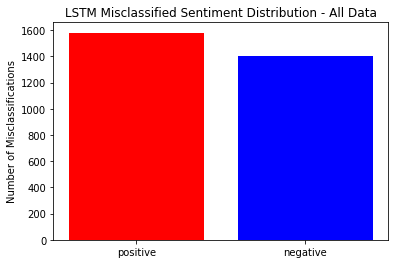

In [ ]:
misclass_pos = misclass_data_readable[misclass_data_readable.sentiment == 'positive']
misclass_neg = misclass_data_readable[misclass_data_readable.sentiment == 'negative']

# Plot misclassified distribution
plt.bar(x=['positive', 'negative'], height=[misclass_pos.shape[0], misclass_neg.shape[0]], color=['red', 'blue'])
plt.title('LSTM Misclassified Sentiment Distribution - All Data')
plt.ylabel('Number of Misclassifications')
plt.savefig(SAVE_PATH + 'figures/LSTM_misclassification_distr_test.png')
plt.show()

In [ ]:
# Plot misclassified distribution
nb_misclass_test_labels = y_test_preds[y_test_preds != y_test]
nb_misclass_test_counts = np.bincount(nb_misclass_labels == 'positive')
lstm_misclass_test_labels = y_test_preds[y_test_preds != y_test]
lstm_misclass_test_counts = lstm_misclass_test_labels.bincount(lstm_misclass_labels == 'positive')
plt.bar(x=['positive', 'negative'], height=[lstm_misclass_test_counts[0], lstm_misclass_test_counts[1]], color=['red', 'blue'])
plt.title('LSTM Misclassified Sentiment Distribution - All Data')
plt.ylabel('Number of Misclassifications')
plt.savefig(SAVE_PATH + 'figures/lstm_test_misclassification_distr.png')
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  


AttributeError: ignored

**Highest Frequency Words Among Misclassifications**

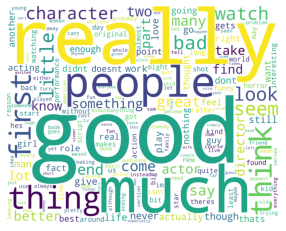

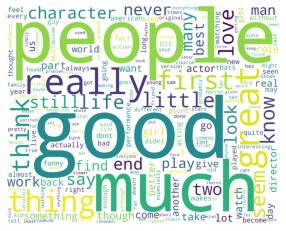

In [ ]:
# Add domain specific stop words
exclude = list(wordcloud.STOPWORDS)
exclude.extend([
                    'film', 'films', 'one', 'movie', 'movies', 'characters', 'director'
                    'character', 'scene', 'scenes', 'story', 'time', 'show', 
                    'even', 'plot', 'make', 'made', 'see', 'well', 'way'
              ])
exclude = set(exclude)

# Generate wordcloud based on most common words in positive/negative reviews
misclass_pos_wordcloud = WordCloud(
                        stopwords=exclude,
                        background_color='white',
                        width=2500,
                        height=2000
                      ).generate(" ".join(misclass_pos['review'].values))
misclass_neg_wordcloud = WordCloud(
                        stopwords=exclude,
                        background_color='white',
                        width=2500,
                        height=2000
                      ).generate(" ".join(misclass_neg['review'].values))

# Display wordcloud images
plt.imshow(misclass_pos_wordcloud)
plt.axis('off')
plt.show()
plt.imshow(misclass_neg_wordcloud)
plt.axis('off')
plt.show()

# Save word clouds
misclass_pos_wordcloud.to_file(SAVE_PATH + 'figures/misclass_pos_cloud.png')
misclass_neg_wordcloud.to_file(SAVE_PATH + 'figures/misclass_neg_cloud.png')

**Highest Frequency Words Among Correct Classifications**

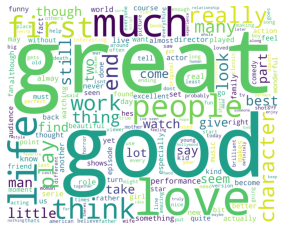

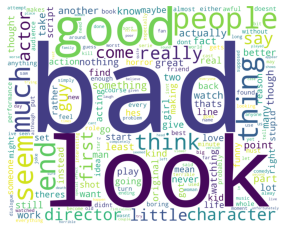

In [ ]:
# Separate correctly classified data 
correct_data_readable = unstemmed_data.loc[y_preds == y_vals]
correct_pos = correct_data_readable[correct_data_readable.sentiment == 'positive']
correct_neg = correct_data_readable[correct_data_readable.sentiment == 'negative']

# Add domain specific stop words
exclude = list(wordcloud.STOPWORDS)
exclude.extend([
                    'film', 'films', 'one', 'movie', 'movies', 'characters', 'director'
                    'character', 'scene', 'scenes', 'story', 'time', 'show', 
                    'even', 'plot', 'make', 'made', 'see', 'well', 'way'
              ])
exclude = set(exclude)

# Generate wordcloud based on most common words in positive/negative reviews
correct_pos_wordcloud = WordCloud(
                        stopwords=exclude,
                        background_color='white',
                        width=2500,
                        height=2000
                      ).generate(" ".join(correct_pos['review'].values))
correct_neg_wordcloud = WordCloud(
                        stopwords=exclude,
                        background_color='white',
                        width=2500,
                        height=2000
                      ).generate(" ".join(correct_neg['review'].values))

# Display wordcloud images
plt.imshow(correct_pos_wordcloud)
plt.axis('off')
plt.show()
plt.imshow(correct_neg_wordcloud)
plt.axis('off')
plt.show()

# Save word clouds
correct_pos_wordcloud.to_file(SAVE_PATH + 'figures/correct_pos_cloud.png')
correct_neg_wordcloud.to_file(SAVE_PATH + 'figures/correct_neg_cloud.png')

**Analyse NB Predictions**

In [ ]:
# Load NB model, vectorizer, and transformer
import pickle5 as pickle
nb_model = pickle.load(open(SAVE_PATH + 'NB/NB_Multinomial.sav', 'rb'))
nb_vectorizer = pickle.load(open(SAVE_PATH + 'NB/count_vectorizer.pickle', 'rb'))
nb_transformer = pickle.load(open(SAVE_PATH + 'NB/TFID_Transformer.pickle', 'rb'))

# Load stemmed data NB was trained on
data = pd.read_csv(SAVE_PATH + 'data/Cleaned_IMDB_Dataset.csv')
x_vals = data['review']
y_vals = data['sentiment']
x_vals = nb_vectorizer.transform(x_vals)
x_vals = nb_transformer.transform(x_vals)

# Randomize and split entire dataset into 80% train, 20% testing
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_vals, y_vals, test_size=.2, random_state=5)
print("Training:", x_train.shape, y_train.shape)
print("Testing:", x_test.shape, y_test.shape)

Training: (40000, 552822) (40000,)
Testing: (10000, 552822) (10000,)


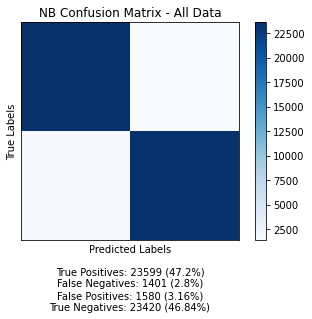

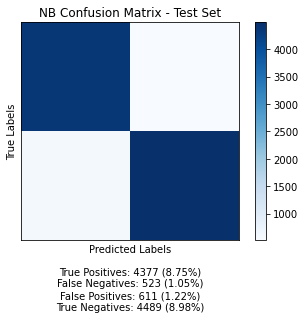

In [ ]:
def get_caption(cm):
  return "\n\nTrue Positives: {} ({}%)\nFalse Negatives: {} ({}%)\nFalse Positives: {} ({}%)\nTrue Negatives: {} ({}%)".format(
    str(cm[0][0]), str(round((cm[0][0]/x_vals.shape[0])*100, 2)),
    str(cm[0][1]), str(round((cm[0][1]/x_vals.shape[0])*100, 2)),
    str(cm[1][0]), str(round((cm[1][0]/x_vals.shape[0])*100, 2)),
    str(cm[1][1]), str(round((cm[1][1]/x_vals.shape[0])*100, 2))
  )

# Generate predictions on full dataset
y_preds = nb_model.predict(x_vals)
cm = confusion_matrix(y_vals, y_preds)

# Plot confusion matrix
plt.imshow(cm, cmap=plt.cm.Blues)
plt.xlabel("Predicted Labels" + get_caption(cm))
plt.ylabel("True Labels")
plt.xticks([], [])
plt.yticks([], [])
plt.title('NB Confusion Matrix - All Data')
plt.colorbar()
plt.savefig(SAVE_PATH + 'figures/nb_confusion_matrix_alldata.png', bbox_inches='tight')
plt.show()


# Generate predictions on testing set
y_test_preds = nb_model.predict(x_test)
cm = confusion_matrix(y_test, y_test_preds)

# Plot confusion matrix
plt.imshow(cm, cmap=plt.cm.Blues)
plt.xlabel("Predicted Labels" + get_caption(cm))
plt.ylabel("True Labels")
plt.xticks([], [])
plt.yticks([], [])
plt.title('NB Confusion Matrix - Test Set')
plt.colorbar()
plt.savefig(SAVE_PATH + 'figures/nb_confusion_matrix_testdata.png', bbox_inches='tight')
plt.show()

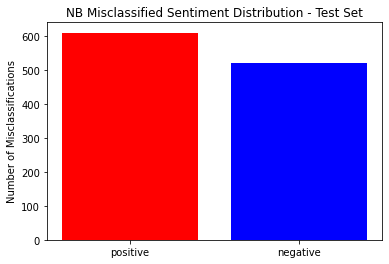

In [ ]:
# Plot misclassified distribution
nb_misclass_test_labels = y_test_preds[y_test_preds != y_test]
nb_misclass_test_counts = np.bincount(nb_misclass_labels == 'positive')
plt.bar(x=['positive', 'negative'], height=[nb_misclass_test_counts[0], nb_misclass_test_counts[1]], color=['red', 'blue'])
plt.title('NB Misclassified Sentiment Distribution - Test Set')
plt.ylabel('Number of Misclassifications')
plt.savefig(SAVE_PATH + 'figures/nb_misclassification_distr.png')
plt.show()

In [ ]:
data_total = x_test.shape[0]
nb_num_incorrect = nb_misclass_test_counts[0] + nb_misclass_test_counts[1]
nb_num_correct = data_total - nb_num_incorrect
nb_pct_correct = round(nb_num_correct / data_total, 4)
print('NB Evaluation - Test Data:')
print('{}/{}\t- accuracy: {}'.format(nb_num_correct, data_total, nb_pct_correct))

NB Evaluation - Test Data:
8866/10000	- accuracy: 0.8866


In [ ]:
print('LSTM Evaluation - Test Data:')


LSTM Evaluation - Test Data:
